In [4]:
import os
import pandas as pd
import actr
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

ACT-R connection has been started.


In [5]:
class MiniModel:
    def __init__(self):
        self.curr_index = 0
        self.curr_onset = 0
        self.curr_offset = 0
        self.curr_production = ""
        self.ordered_productions = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]
        self.production_at = np.arange(0, 10)/100+0.01
        self.production_reward = [0,1,2,3,4,5,6,7,8,9]
        
        self.trial_trace = []
        self.production_trace = []
        self.reward_trace = []
        self.utility_trace = []
    
    def load_model(self):
        curr_dir = os.path.dirname(os.path.realpath('__file__'))
        actr.load_act_r_model(os.path.join(curr_dir, "mini-model.lisp"))
        actr.pdisable('retrieve-rule')
        self.setup_parameters()
    
    def cost_function(self, x, c=1):
        #return np.round(np.exp(c*x)-1, 4)
        return x*c
        
    def setup_parameters(self):
        actr.hide_output()
        # set at parameter
        #clist = self.cost_function(np.arange(0, 10)/100+0.01)
        self.production_at = self.cost_function(self.production_at)
        for i in range(len(self.ordered_productions)):
            actr.spp(self.ordered_productions[i], ":at", self.production_at[i], ":reward", self.production_reward[i])
        actr.spp("DONE", ":reward", 1)
        actr.unhide_output() 

    def production_hook(self, *params):
        #print('in p hook', params)
        production = params[0]
        if production == "START-TRIAL":
            self.curr_index += 1
            self.curr_onset = actr.mp_time()
        elif production == "DONE":
            self.curr_offset = actr.mp_time()
            self.trial_trace.append((self.curr_index, self.curr_production, np.round(self.curr_offset-self.curr_onset, 2)))
            #print(self.curr_index, self.curr_onset, self.curr_offset, self.curr_offset-self.curr_onset)
        elif production in self.ordered_productions:
            self.production_trace.append((self.curr_index, production, actr.mp_time()))
            self.curr_production = production
        return production
    
    def reward_hook(self, *params):
        production = params[0]
        delivered_reward = params[1]
        discounted_reward = params[2]
        if production in self.ordered_productions:
            #print('in reward hook', production)
            self.reward_trace.append((self.curr_index, production, actr.mp_time(), delivered_reward, discounted_reward))
        return (params)

    def utility_hook(self, *params):
        #print('u', len(params), params)
        # NEW: record the production utility
        #self.current_trial.utility_trace=[self.extract_production_parameter('PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('PROCESS-LOCATION', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-SHAPE', ':u'),
        #                                     self.extract_production_parameter('DONT-PROCESS-LOCATION', ':u')]
        #print(self.extract_production_parameter('P1', ':u'))
        pass
          
    def extract_production_parameter(self, production_name, parameter_name):
        """
        This function will extract the parameter value of a production during model running
        """
        assert (production_name in actr.all_productions() and
                parameter_name in [':u', ':utility', ':at', ':reward', ':fixed-utility'])
        actr.hide_output()
        value = actr.spp(production_name, parameter_name)[0][0]
        actr.unhide_output()
        return (production_name, parameter_name, value)
    
    
    
    def df_data(self):
        df_trial_trace = pd.DataFrame(self.trial_trace, columns=['trial', 'production', 'response_time'])
        df_production_trace = pd.DataFrame(self.production_trace, columns=['trial', 'production', 'firing_time'])
        df_reward_trace = pd.DataFrame(self.reward_trace, columns=['trial', 'production', 'rewarded_time', 'delivered_reward', 'passed_time'])
        
        return df_trial_trace, df_production_trace, df_reward_trace 
        #m.production_trace
        #m.reward_trace
        #m.utility_trace
        
def simulate(n=1, time=1000):
    simulated_results = []
    for i in range(n):
        print("==== SIMULATED ==== n >>", i)
        m = MiniModel()
        actr.add_command("production-hook",m.production_hook)
        actr.add_command("reward-hook", m.reward_hook)
        actr.add_command("utility-hook", m.utility_hook)
        actr.schedule_event_relative(0.01, "production-hook")
        actr.schedule_event_relative(0.01, "reward-hook")
        actr.schedule_event_relative(0.01, "utility-hook")

        m.load_model()
        actr.run(time)
        actr.remove_command("production-hook")
        actr.remove_command("reward-hook")
        actr.remove_command("utility-hook")
        simulated_results.append(m)
    return simulated_results

## Simulate Model


In [18]:
simulated_results = simulate(n=10,time=1000)

==== SIMULATED ==== n >> 0
==== SIMULATED ==== n >> 1
==== SIMULATED ==== n >> 2
==== SIMULATED ==== n >> 3
==== SIMULATED ==== n >> 4
==== SIMULATED ==== n >> 5
==== SIMULATED ==== n >> 6
==== SIMULATED ==== n >> 7
==== SIMULATED ==== n >> 8
==== SIMULATED ==== n >> 9


## Data 

In [19]:
n = len(simulated_results)
df1s = []
df2s = []
df3s = []
for i in range(n):
    df1, df2, df3 = simulated_results[i].df_data()
    df1s.append(df1)
    df2s.append(df2)
    df3s.append(df3)
df1 = pd.concat(df1s, axis=0)
df2 = pd.concat(df2s, axis=0)
df3 = pd.concat(df3s, axis=0)

In [20]:
df1.head()

,trial,production,response_time
0,1,P4,0.14
1,2,P8,0.18
2,3,P8,0.18
3,4,P8,0.18
4,5,P8,0.18


In [21]:
df2.head()

,trial,production,firing_time
0,1,P4,0.09
1,2,P8,0.32
2,3,P8,0.55
3,4,P8,0.78
4,5,P8,1.01


In [22]:
df3.head()

,trial,production,rewarded_time,received_reward,passed_time
0,1,P4,0.09,3,0.04
1,2,P8,0.32,7,0.08
2,3,P8,0.55,7,0.08
3,4,P8,0.78,7,0.08
4,5,P8,1.01,7,0.08


In [24]:
df3['received_reward'] = df3['delivered_reward']-df3['passed_time']
df3

,Unnamed: 0,trial,production,rewarded_time,delivered_reward,passed_time,received_reward
0,0,1,P4,0.09,3,0.04,2.96
1,1,2,P8,0.32,7,0.08,6.92
2,2,3,P8,0.55,7,0.08,6.92
3,3,4,P8,0.78,7,0.08,6.92
4,4,5,P8,1.01,7,0.08,6.92
...,...,...,...,...,...,...,...
43190,4489,4490,P10,998.83,9,0.10,8.90
43191,4490,4491,P10,999.08,9,0.10,8.90
43192,4491,4492,P10,999.33,9,0.10,8.90
43193,4492,4493,P10,999.58,9,0.10,8.90


In [21]:
save = False
todays_date = date.today().strftime("%Y%m%d")
if save:
    curr_dir = os.path.dirname(os.path.realpath('__file__'))
    df1.to_csv(os.path.join(curr_dir, "mini_model_df1_{}.txt".format(todays_date)), index=False)
    df2.to_csv(os.path.join(curr_dir, "mini_model_df2_{}.txt".format(todays_date)), index=False)
    df3.to_csv(os.path.join(curr_dir, "mini_model_df3_{}.txt".format(todays_date)), index=False)
else:
    try:
        df1 = pd.read_csv(os.path.join(curr_dir, "mini_model_df1_{}.txt".format(todays_date)))
        df2 = pd.read_csv(os.path.join(curr_dir, "mini_model_df2_{}.txt".format(todays_date)))
        df3 = pd.read_csv(os.path.join(curr_dir, "mini_model_df3_{}.txt".format(todays_date)))
    except:
        print("No saved data!")

## Visualize Output

In [15]:
order=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9", "P10"]

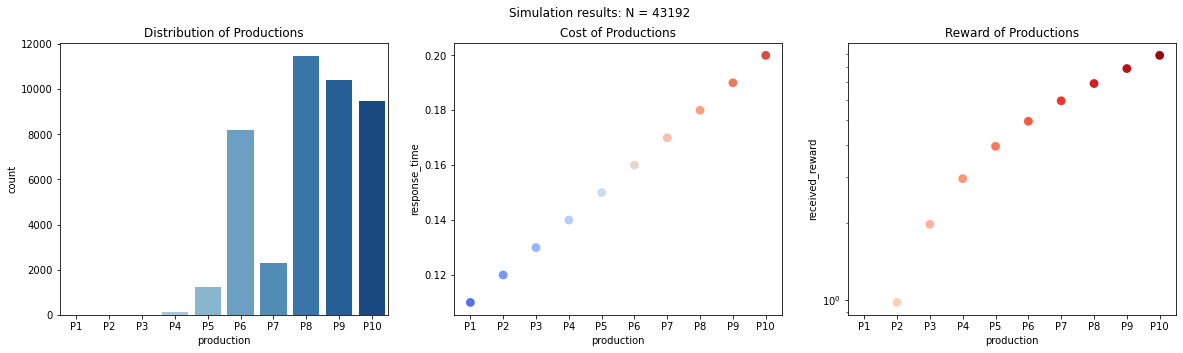

In [32]:
fig, ax =plt.subplots(1,3, figsize=(20,5))
fig.suptitle("Simulation results: N = {}".format(len(df1)))
sns.countplot(x=df1['production'], order=order, palette="Blues", ax=ax[0]).set_title('Distribution of Productions')
sns.pointplot(x="production", y="response_time", order=order, data=df1, palette="coolwarm", ax=ax[1]).set_title('Cost of Productions')
sns.pointplot(x="production", y="received_reward", data=df3, order=order, palette="Reds", ax=ax[2]).set_title('Reward of Productions')
#ax[2].set(yscale="log")
plt.show()

In [38]:
df1[['production', 'response_time']].groupby('production').agg(['mean', 'std'])

response_time     
                    mean  std
production                   
P1                  0.11  NaN
P10                 0.20  0.0
P2                  0.12  0.0
P3                  0.13  0.0
P4                  0.14  0.0
P5                  0.15  0.0
P6                  0.16  0.0
P7                  0.17  0.0
P8                  0.18  0.0
P9                  0.19  0.0

In [39]:
df3[['production', 'delivered_reward', 'received_reward']].groupby('production').agg(['mean', 'std'])

delivered_reward      received_reward     
                       mean  std            mean  std
production                                           
P1                        0  NaN           -0.01  NaN
P10                       9  0.0            8.90  0.0
P2                        1  0.0            0.98  0.0
P3                        2  0.0            1.97  0.0
P4                        3  0.0            2.96  0.0
P5                        4  0.0            3.95  0.0
P6                        5  0.0            4.94  0.0
P7                        6  0.0            5.93  0.0
P8                        7  0.0            6.92  0.0
P9                        8  0.0            7.91  0.0